In [ ]:
pip install Pillow

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output

In [ ]:
pip install pytesseract

<ipython-input-4-f8a7e364cafd>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


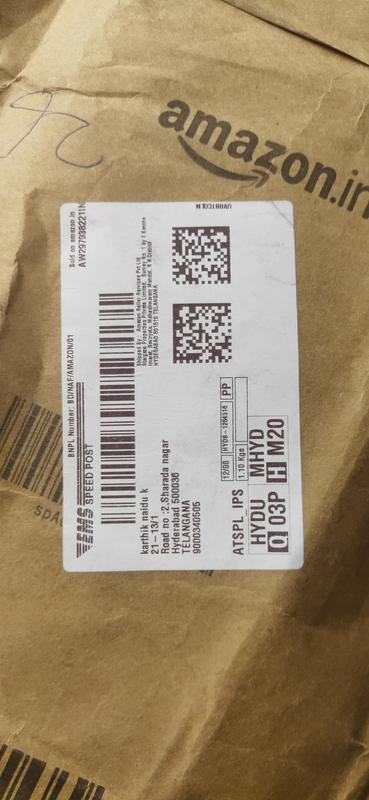

In [ ]:
# Sample file out of the dataset
file_name = '/content/IMG 2023090907.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [ ]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [ ]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [ ]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

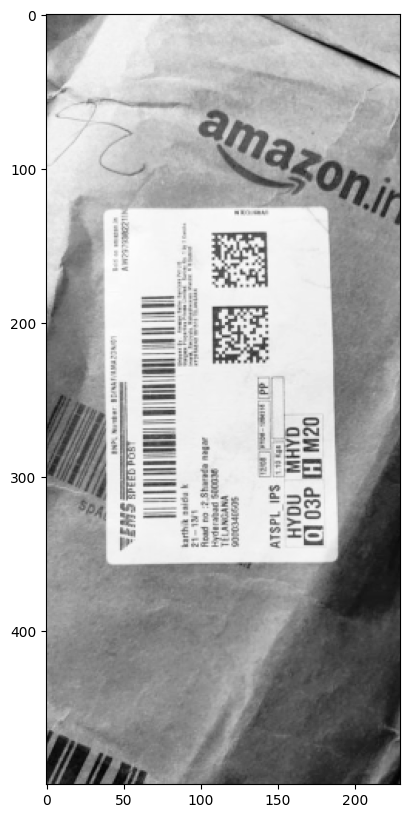

In [ ]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

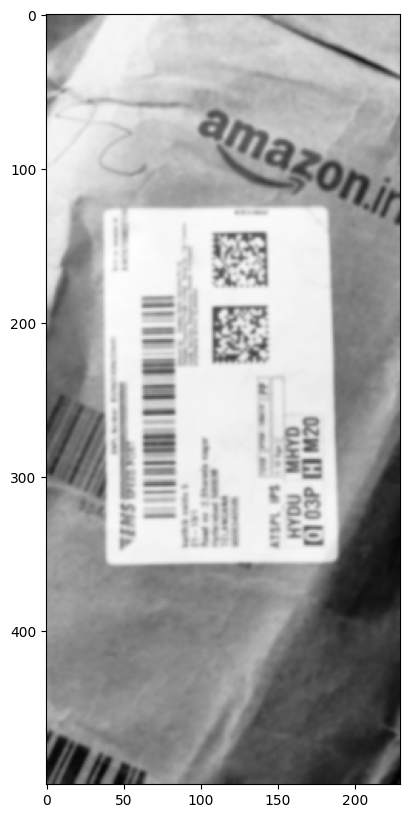

In [ ]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

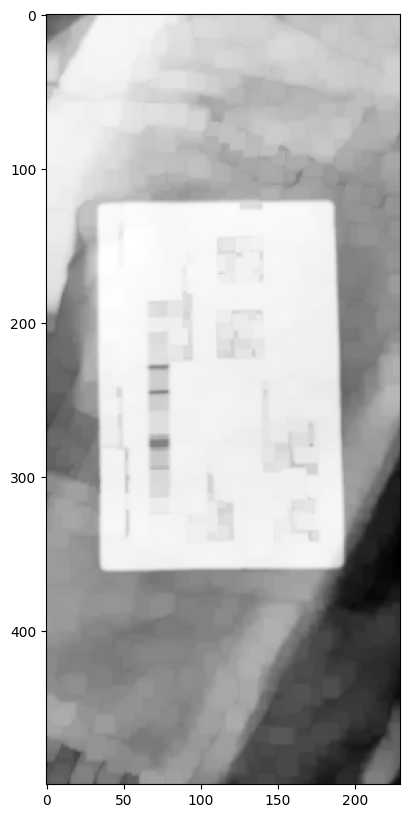

In [ ]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

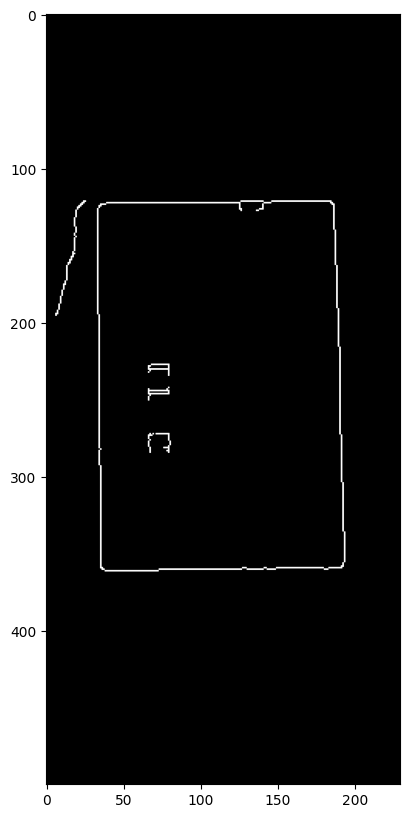

In [ ]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

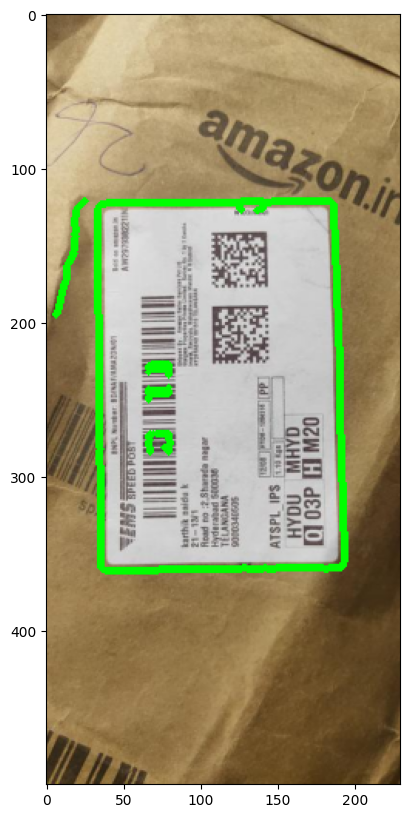

In [ ]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

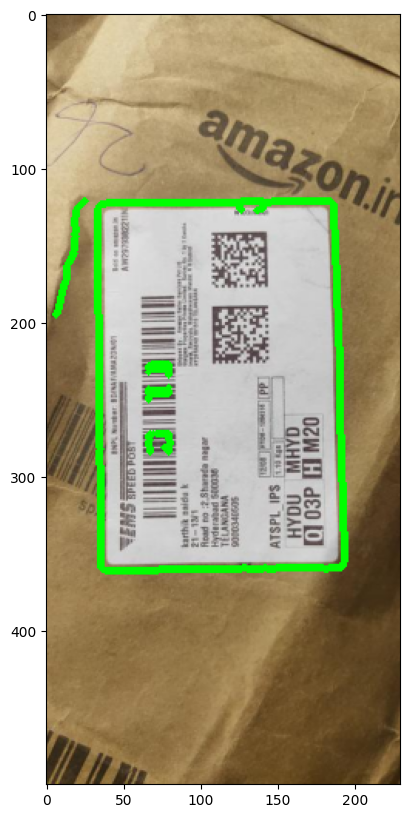

In [ ]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [ ]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [ ]:
def get_receipt_contour(contours):
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [ ]:
get_receipt_contour(largest_contours)

array([[[184, 121]],

       [[ 34, 124]],

       [[ 36, 360]],

       [[192, 358]]], dtype=int32)

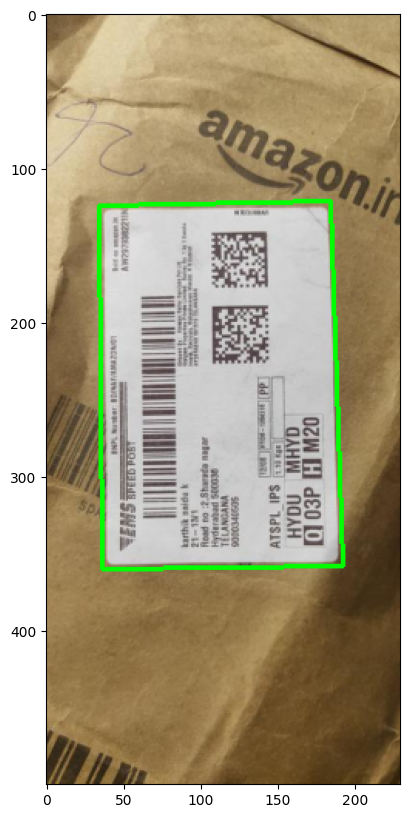

In [ ]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [ ]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [ ]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

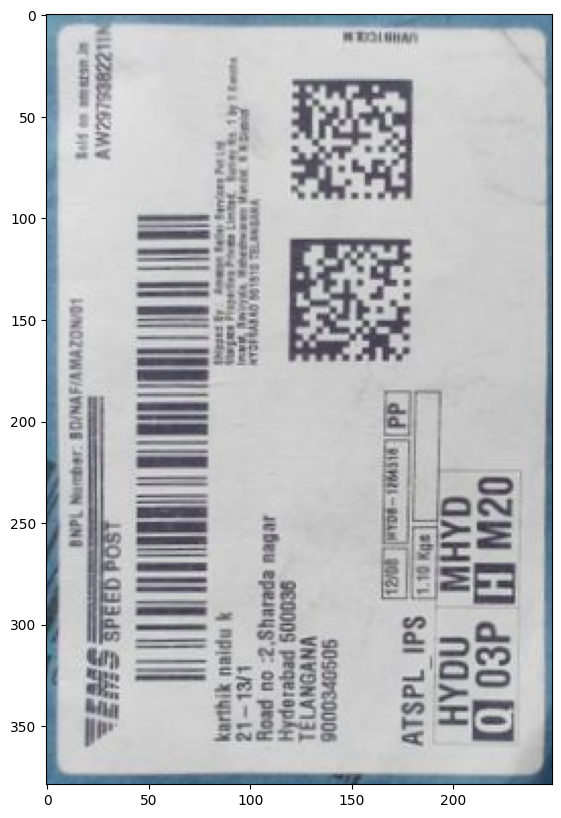

In [ ]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [ ]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

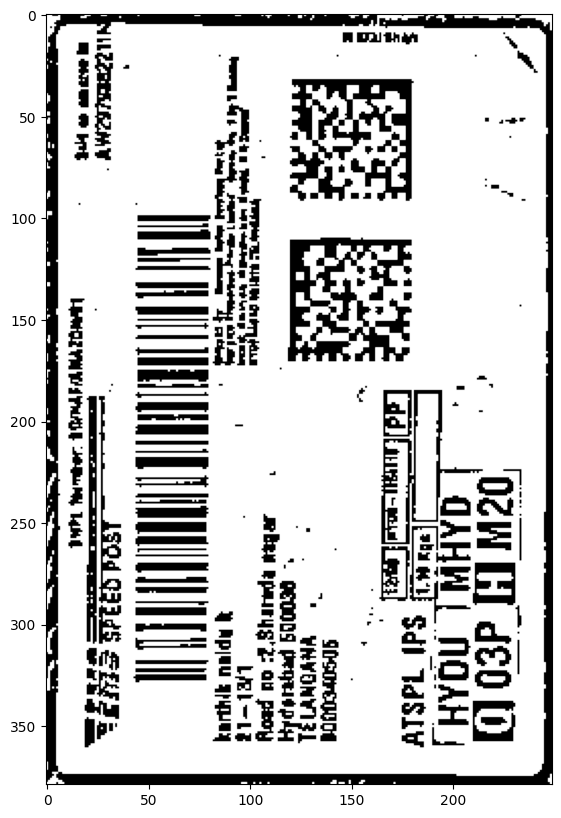

In [ ]:
result = bw_scanner(scanned)
plot_gray(result)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # Use this for displaying images in Colab

# Load the input image
input_image = cv2.imread('/content/result.png')

# Convert the image to grayscale
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)  # Adjust thresholds as needed

# Find contours in the edge image
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on a copy of the original image (for visualization)
image_with_contours = input_image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Color: Green, Thickness: 2




array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

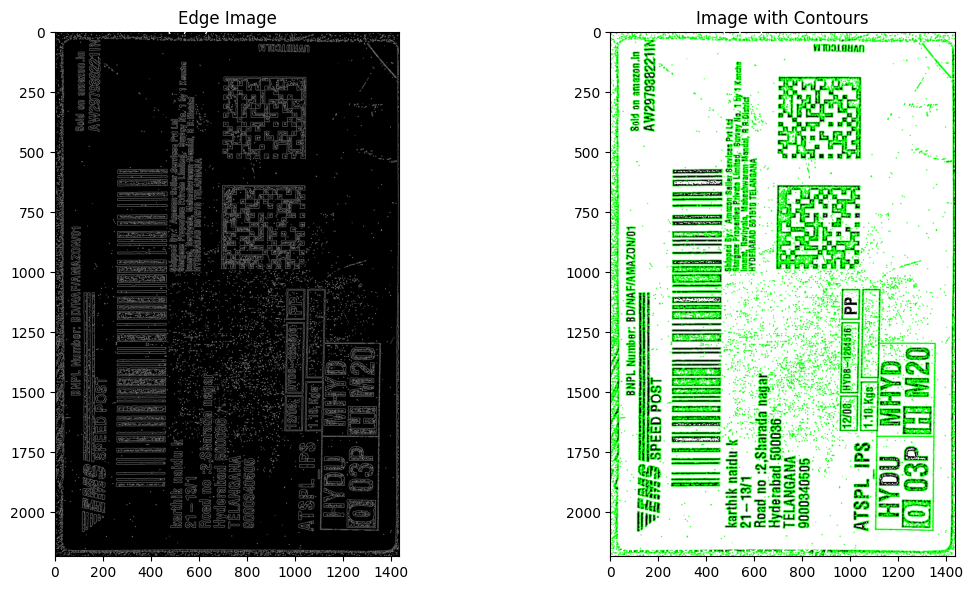

In [ ]:
from matplotlib import pyplot as plt

# Define the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the edge image on the first subplot (ax1)
ax1.imshow(edges, cmap='gray')  # Assuming 'edges' is the edge image
ax1.set_title('Edge Image')
ax1.axis('on')  # Show axes

# Annotate the first subplot with its coordinates
ax1.annotate(f'Coordinates: (0, 0)', (0, 0), color='white', fontsize=12)

# Display the original image with contours on the second subplot (ax2)
ax2.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
ax2.set_title('Image with Contours')
ax2.axis('on')  # Show axes

# Get the dimensions of the image_with_contours
height, width, _ = image_with_contours.shape

# Annotate the second subplot with its coordinates
ax2.annotate(f'Coordinates: (0, 0)', (0, 0), color='white', fontsize=12)
ax2.annotate(f'Dimensions: ({width}, {height})', (10, height - 20), color='white', fontsize=12)

# Adjust the subplots layout
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# Save the image with contours
cv2.imwrite('image_with_contours.jpg', image_with_contours)

True

In [ ]:
!apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.6 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-en

In [ ]:
! pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 23.4 MB/s eta 0:00:00


In [ ]:
import easyocr
reader = easyocr.Reader(['en'])

In [ ]:
result = reader.readtext('/content/result.png',paragraph=True)

In [ ]:
result

[[[[168, 57], [1383, 57], [1383, 234], [168, 234]],
  'BNPL Number; BDINAFIAMAZON/O1 E519 SEEDPo87'],
 [[[1763, 77], [2167, 77], [2167, 199], [1763, 199]],
  '8old on amazon .In Aw297938221IN'],
 [[[106, 475], [774, 475], [774, 841], [106, 841]],
  "karthik naidu 21 = 13/1 Road no :2,Sharada nagar' Hyderabad 500036 TELANGANA 9000340505"],
 [[[1173, 467], [2067, 467], [2067, 625], [1173, 625]],
  '8hlpped Siargaze @xopez0} Baller Gxctcesgu4i Prlvate Limilcd,  Survav_Ole; 1 by Kancha HYSehaak 887673h LA/5a Anandan, R E Diatrig 601510 TELANGAHA'],
 [[[94, 957], [1085, 957], [1085, 1347], [94, 1347]],
  '112708 HYDR 712657576 PP ATSPL IPS 1.10,Kgs hDU MFYD ] 03P HL M2o'],
 [[[2090, 839], [2141, 839], [2141, 1066], [2090, 1066]], '|'],
 [[[631, 1425], [677, 1425], [677, 1437], [631, 1437]], 'R']]

In [ ]:
import cv2
top_left = tuple(result[0][0][0])
bottom_right = tuple(result[0][0][2])
text = result[0][1]
font = cv2.FONT_HERSHEY_SIMPLEX

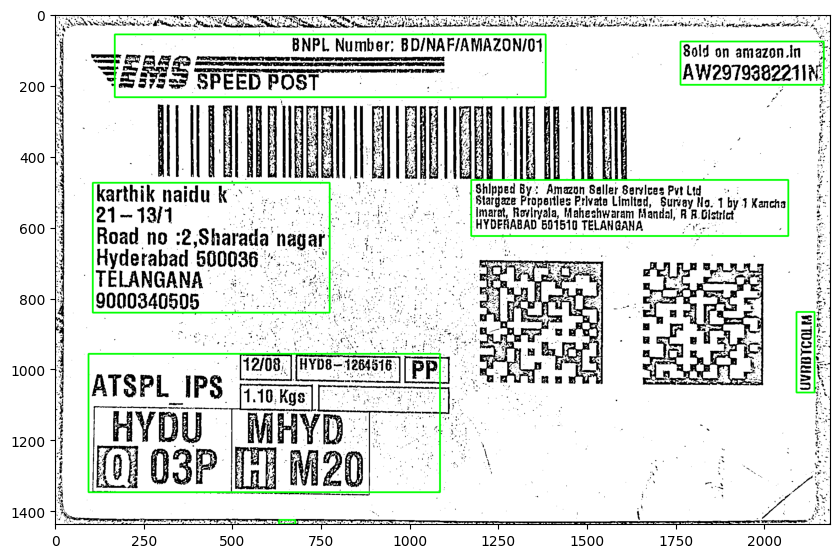

In [ ]:
img = cv2.imread('/content/result.png')
spacer = 300
font = cv2.FONT_HERSHEY_SIMPLEX
for detection in result:
    top_left = tuple(detection[0][0])
    bottom_right = tuple(detection[0][2])
    text = detection[1]
    img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
    #img = cv2.putText(img,text,(20,spacer), font, 0.5,(255,255,0),2,cv2.LINE_AA)
    spacer+=15
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [ ]:
for i in result:
  print(i[1])

BNPL Number; BDINAFIAMAZON/O1 E519 SEEDPo87
8old on amazon .In Aw297938221IN
karthik naidu 21 = 13/1 Road no :2,Sharada nagar' Hyderabad 500036 TELANGANA 9000340505
8hlpped Siargaze @xopez0} Baller Gxctcesgu4i Prlvate Limilcd,  Survav_Ole; 1 by Kancha HYSehaak 887673h LA/5a Anandan, R E Diatrig 601510 TELANGAHA
112708 HYDR 712657576 PP ATSPL IPS 1.10,Kgs hDU MFYD ] 03P HL M2o
|
R


In [ ]:
import re

def extract_pincode(text):

    pincode_pattern = re.compile(r'\b\d{6}\b')


    matches = pincode_pattern.findall(text)


    return matches[0] if matches else None

extracted_text = """
BNPL Number; BDINAFIAMAZON/O1 E519 SEEDPo87
8old on amazon .In Aw297938221IN
karthik naidu 21 = 13/1 Road no :2,Sharada nagar' Hyderabad 500036 TELANGANA 9000340505
8hlpped Siargaze @xopez0} Baller Gxctcesgu4i Prlvate Limilcd,  Survav_Ole; 1 by Kancha HYSehaak 887673h LA/5a Anandan, R E Diatrig 601510 TELANGAHA
112708 HYDR 712657576 PP ATSPL IPS 1.10,Kgs hDU MFYD ] 03P HL M2o
"""


pincode = extract_pincode(extracted_text)


if pincode:
    print("PIN Code found:", pincode)
else:
    print("No PIN Code found.")



PIN Code found: 500036


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.8/731.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.1-py3-none-any.whl size=21122 sha256=8fd97704f7d671edffe9470c412a4417427d6875e0ba13e22bab8939646c861e
  Stored in directory: /root/.cache/pip/wheels/3b/32/0e/27789b6fde02bf2b320d6f1a0fd9e1354b257c5f75eefc29bc
Successfully built pyngrok


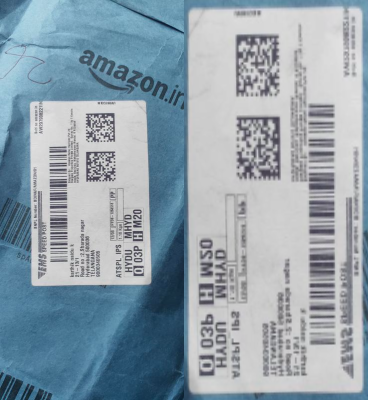

OCR Result:
[[[[10, 311], [60, 311], [60, 382], [10, 382]], '8 8}']]
Extracted PIN Code:
No PIN Code found.


In [ ]:
from PIL import Image
import numpy as np
from skimage.filters import threshold_local
import cv2
import easyocr
import re
from google.colab.patches import cv2_imshow

def extract_pincode(text):
    text_str = str(text)  # Convert to string
    pincode_pattern = re.compile(r'\b\d{6}\b')
    matches = pincode_pattern.findall(text_str)
    return matches[0] if matches else None

# ... (rest of the code remains unchanged)


def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

def contour_to_rect(contour):
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    return approx.reshape(-1, 2).astype(np.float32)

def wrap_perspective(img, rect):
    dst = np.array([
        [0, 0],
        [img.shape[1] - 1, 0],
        [img.shape[1] - 1, img.shape[0] - 1],
        [0, img.shape[0] - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset=5, method="gaussian")
    return (gray > T).astype("uint8") * 255

def main():
    # User input for image
    uploaded_file = Image.open("/content/IMG 2023090907.jpg")  # Change this path to your image

    # Convert to OpenCV format
    image_cv2 = np.array(uploaded_file)

    # Perform image processing steps
    img = opencv_resize(image_cv2, 0.5)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilated = cv2.dilate(blurred, rectKernel)
    edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    receipt_contour = largest_contours[0]  # or choose the index that corresponds to the desired contour

    scanned = wrap_perspective(img.copy(), contour_to_rect(receipt_contour))
    result = bw_scanner(scanned)

    # Perform OCR on the scanned image
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(result, paragraph=True)

    # Extract PIN code from OCR result
    pincode = extract_pincode(ocr_result)

    # Resize images to have the same height
    min_height = min(image_cv2.shape[0], scanned.shape[0])
    image_cv2_resized = opencv_resize(image_cv2, min_height / image_cv2.shape[0])
    scanned_resized = opencv_resize(scanned, min_height / scanned.shape[0])

    # Display the original and processed images
    concatenated_image = np.concatenate([image_cv2_resized, scanned_resized], axis=1)
    cv2_imshow(concatenated_image)

    # Display the OCR result
    print("OCR Result:")
    print(ocr_result)

    # Display the extracted PIN code
    print("Extracted PIN Code:")
    if pincode:
        print("PIN Code:", pincode)
    else:
        print("No PIN Code found.")

if __name__ == "__main__":
    main()